In [1]:
import heapq

class Event:
    '''
    Store the properties of one event in the Schedule class defined below. Each
    event has a time at which it needs to run, a function to call when running
    the event, along with the arguments and keyword arguments to pass to that
    function.
    '''
    def __init__(self, timestamp, function, *args, **kwargs):
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        '''
        This overloads the less-than operator in Python. We need it so the
        priority queue knows how to compare two events. We want events with
        earlier (smaller) times to go first.
        '''
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        Run an event by calling the function with its arguments and keyword
        arguments. The first argument to any event function is always the
        schedule in which events are being tracked. The schedule object can be
        used to add new events to the priority queue.
        '''
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Implement an event schedule using a priority queue. You can add events and
    run the next event.
    
    The `now` attribute contains the time at which the last event was run.
    '''
    
    def __init__(self):
        self.now = 0  # Keep track of the current simulation time
        self.priority_queue = []  # The priority queue of events to run
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # Add an event to the schedule at a particular point in time.
        heapq.heappush(
            self.priority_queue,
            Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        # Add an event to the schedule after a specified time interval.
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        return self.priority_queue[0].timestamp

    def run_next_event(self):
        # Get the next event from the priority queue and run it.
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return (
            f'Schedule() at time {self.now} ' +
            f'with {len(self.priority_queue)} events in the queue')
    
    def print_events(self):
        print(repr(self))
        for event in sorted(self.priority_queue):
            print(f'   {event.timestamp}: {event.function.__name__}')


In [2]:
# M/D/1 queue

import scipy.stats as sts


class Queue:
    def __init__(self, service_rate):
        # Store the deterministic service time for an M/D/1 queue
        self.service_time = 1 / service_rate
        # We start with an empty queue and the server not busy
        self.people_in_queue = 0
        self.people_being_served = 0

    def add_customer(self, schedule):
        # Add the customer to the queue
        self.people_in_queue += 1
        if self.people_being_served < 1:
            # This customer can be served immediately
            schedule.add_event_after(0, self.start_serving_customer)
            
    def start_serving_customer(self, schedule):
        # Move the customer from the queue to a server
        self.people_in_queue -= 1
        self.people_being_served += 1
        # Schedule when the server will be done with the customer
        schedule.add_event_after(
            self.service_time,
            self.finish_serving_customer)
            
    def finish_serving_customer(self, schedule):
        # Remove the customer from the server
        self.people_being_served -= 1
        if self.people_in_queue > 0:
            # There are more people in the queue so serve the next customer
            schedule.add_event_after(0, self.start_serving_customer)


class BusSystem:
    
    def __init__(self, arrival_rate, service_rate):
        self.queue = Queue(service_rate)
        self.arrival_distribution = sts.expon(scale=1/arrival_rate)

    def add_customer(self, schedule):
        # Add this customer to the queue
        self.queue.add_customer(schedule)
        # Schedule when to add another customer
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)

    def run(self, schedule):
        # Schedule when the first customer arrives
        schedule.add_event_after(
            self.arrival_distribution.rvs(),
            self.add_customer)
        

def run_simulation(arrival_rate, service_rate, run_until):
    schedule = Schedule()
    bus_system = BusSystem(arrival_rate, service_rate)
    bus_system.run(schedule)
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()
    return bus_system

## Start with an arrival rate of 0.8 and a service rate of 1.

In [20]:
# Run a short test
bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=200)
print(f'There are {bus_system.queue.people_in_queue} people in the queue')

There are 0 people in the queue


## Repeat the trial 100 times

In [22]:
q_length = []
for i in range(100):
    bus_system = run_simulation(arrival_rate=0.8, service_rate=1, run_until=200)
    q_length.append(bus_system.queue.people_in_queue)
print((q_length))

[3, 0, 2, 0, 1, 1, 0, 4, 2, 4, 1, 0, 3, 1, 3, 0, 1, 0, 2, 3, 2, 7, 0, 1, 2, 3, 0, 2, 0, 0, 0, 3, 1, 0, 4, 0, 1, 3, 0, 1, 2, 1, 0, 8, 0, 0, 3, 0, 4, 1, 0, 0, 5, 0, 16, 3, 1, 0, 0, 3, 4, 1, 0, 1, 0, 0, 7, 0, 1, 0, 4, 0, 1, 0, 0, 0, 4, 0, 6, 0, 2, 1, 3, 0, 0, 5, 0, 0, 2, 2, 0, 0, 1, 1, 1, 0, 2, 2, 0, 5]


Plot the histogram

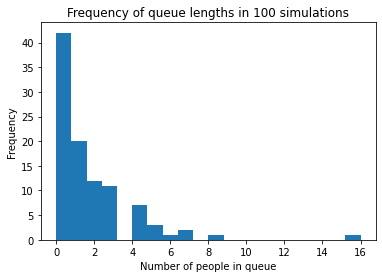

In [27]:
import matplotlib.pyplot as plt

plt.hist(q_length, bins=20)
plt.title("Frequency of queue lengths in 100 simulations")
plt.xlabel("Number of people in queue")
plt.ylabel("Frequency")
plt.show()

In [33]:
import numpy as np
import scipy.stats as sts
# Average queue length
mean = np.mean(q_length)
print("The average queue length is ", mean)

#95% Confidence interval of average queue length
std_err_mean = sts.sem(q_length)
np.std(q_length)
print("95% confidence interval of average queue length is: ",
      [mean + 1.96*std_err_mean, mean - 1.96*std_err_mean])


The average queue length is  1.64
95% confidence interval of average queue length is:  [2.097350302715478, 1.182649697284522]


## Repeat the simulation 1000 times

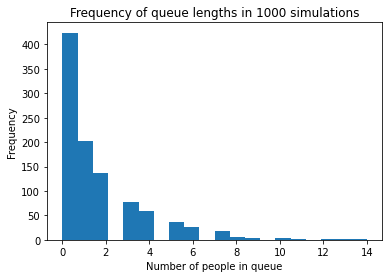

In [29]:
q_length_1000 = []
for i in range(1000):
    bus_system = run_simulation(
        arrival_rate=0.8, service_rate=1, run_until=200)
    q_length_1000.append(bus_system.queue.people_in_queue)
plt.hist(q_length_1000, bins=20)
plt.title("Frequency of queue lengths in 1000 simulations")
plt.xlabel("Number of people in queue")
plt.ylabel("Frequency")
plt.show()


Compute the average queue length and its confidence interval

In [34]:

# Average queue length
mean = np.mean(q_length_1000)
print("The average queue length is ", mean)

#95% Confidence interval of average queue length
std_err_mean = sts.sem(q_length_1000)
np.std(q_length_1000)
print("95% confidence interval of average queue length is: ", [mean + 1.96*std_err_mean, mean - 1.96*std_err_mean])


The average queue length is  1.618
95% confidence interval of average queue length is:  [1.752839008895497, 1.4831609911045032]


## Compare the two results

1. Whether and how the distribution (histogram) over queue length changed.

    - Both distibutions follow exponential distribution
    - However, when we run 1000 simulations, the histogram seems "smoother", ie the line seems to be more predictable. Furthermore, there was no distribution for queue length above 14, while with 100 simulations there were a few rare cases.
    
2. Whether and how the average queue length estimate changed.

- The average for 100 simulations is 1.64, while the avg for 1000 simulations is 1.618. So the average didn't change much

3. Whether and how the confidence interval of the average queue length changed.

- The 95% confidence interval of 1000 simulations is significantly smaller than the 100 simulations:
[1.483, 1.753] versus [1.182, 2.097]

## Repeat the experiment but for different values of the arrival rate

Make an error plot of
the average queue length and its 95% confidence interval for different values of the arrival
rate and determine when the average queue length exceeds 5 people.

In [42]:
arrival_rates = [0.8, 1, 1.2, 1.5, 2, 4]
# Get all the simulation result
queue_length_dict = {}
for arrival_rate in arrival_rates:
    q_length = []
    for i in range(1000):
        bus_system = run_simulation(
            arrival_rate=arrival_rate, service_rate=1, run_until=100)
        q_length.append(bus_system.queue.people_in_queue)
    queue_length_dict[arrival_rate] = q_length


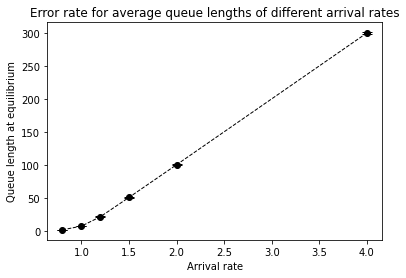

In [46]:
# Get the 95% confidence intervals for each arrival rate
means = []
y_errs = []
for rate in queue_length_dict:
    mean = np.mean(queue_length_dict[rate])
    std_err_mean = sts.sem(queue_length_dict[rate])
    ci = [mean + 1.96*std_err_mean, mean - 1.96*std_err_mean]
    y_err = (ci[0] - ci[1])/2
    means.append(mean)
    y_errs.append(y_err)

plt.errorbar(
    arrival_rates, means, y_errs,
    color='black', marker='o', capsize=5, linestyle='--', linewidth=1)

plt.title("Error rate for average queue lengths of different arrival rates")
plt.xlabel("Arrival rate")
plt.ylabel("Queue length at equilibrium")
plt.show()

The average queue length exceeds 5 when arrival rate is around 0.95

## Reflection

#EmpiricalAnalysis:

- The result is interpreted: for example, in the part where I compare the difference between the confidence intervals of running 1000 versus 100 simulations. 
- The stats analysis all follow the code from study guide

#Professionalism:
- The code is clean and well-documented
- All the graphs have labels and titles